<a href="https://colab.research.google.com/github/JuniorHZ19/ArquitecturasCNN/blob/main/VGG-NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
#VGG-Net:
import torch
import torch.nn as nn

class VGGNet(nn.Module):
    def __init__(self,input_channel=3,arch=None,num_classes=10):
        super(VGGNet, self).__init__()

        self.incial_channel=input_channel

        vgg_blocks=[]

        for (num_conv,channels) in arch:
            vgg_blocks.append(self.vgg_block(num_conv,channels))

        self.vgg_net=nn.Sequential(*vgg_blocks,
                                   nn.Flatten(),

                                   nn.LazyLinear(4096),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),

                                   nn.Linear(4096,4096),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),

                                   nn.Linear(4096,num_classes)
                                   )


    def forward(self, x):

        x=self.vgg_net(x)

        return x


    def vgg_block(self,num_conv,channels):

     layers=[]

     for i in range(num_conv):
       if(i==0):

        layers.append(nn.Conv2d(self.incial_channel,channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        self.incial_channel=channels

       else:
        layers.append(nn.Conv2d(channels,channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())

     layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
     return nn.Sequential(*layers)


In [3]:
import torch

# Definir la función de precisión (accuracy)
def accuracy(predicciones, etiquetas_reales, multiclase=False):
    if not multiclase:
        # Para problemas binarios o de clasificación de 2 clases
        predicciones_clase = predicciones.round()
    else:
        # Para clasificación multiclase, usar argmax
        predicciones_clase = torch.argmax(predicciones, dim=1)

    # Contar los aciertos
    aciertos = (predicciones_clase.squeeze() == etiquetas_reales).sum().item()

    # Calcular la precisión
    accuracy = aciertos / len(etiquetas_reales)

    return accuracy

In [4]:
from tqdm.notebook import trange, tqdm

def trainModel(model, epochs, dataLoader, dataLoader_test, optimiser, funcion_loss, multiclase=True):
    model.to(device)

    # Barra de progreso para las épocas
    pbar_epochs = tqdm(total=epochs, desc='Épocas', position=0, leave=True)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()  # Establecer el modelo en modo de entrenamiento

        # Barra de progreso para el dataloader (para cada época)
        pbar_dataloader = tqdm(dataLoader, desc=f'Epoca {epoch+1} - Dataloader',unit='batches', position=1, leave=True)

        for batch_data, batch_labels in dataLoader:
            # Mover los datos a la GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # Hacer la predicción
            output = model(batch_data)

            # Calcular la pérdida
            loss = funcion_loss(output, batch_labels)

            # Reiniciar los gradientes
            optimiser.zero_grad()

            # Retropropagación
            loss.backward()

            # Optimización
            optimiser.step()

            epoch_loss += loss.item()

            # Actualizar la barra de progreso del dataloader
            pbar_dataloader.set_postfix(batch_loss=loss.item())  # Mostrar la pérdida en la barra
            pbar_dataloader.update(1)

        # Establecer el modelo en modo evaluación
        model.eval()
        accuracy_total = 0
        with torch.no_grad():
            for batch_data, batch_labels in dataLoader_test:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)  # Mover los datos a la GPU
                output = model(batch_data)

                # Calcular la precisión
                accuracy_total += accuracy(output, batch_labels, multiclase)

        # Calcular el promedio de la precisión
        accuracy_promedio = accuracy_total / len(dataLoader_test)

        # Calcular el promedio de la pérdida
        epoch_loss /= len(dataLoader)

        # Imprimir el progreso de la época
        print(f"Época {epoch+1}, Pérdida: {epoch_loss:.4f}, Precisión: {accuracy_promedio:.4f}")

        # Actualizar la barra de progreso de épocas
        pbar_epochs.update(1)
        pbar_dataloader.close()  # Cerrar barra de progreso del dataloader al final de la época

    # Cerrar la barra de progreso de las épocas
    pbar_epochs.close()

    return model, optimiser

Files already downloaded and verified
Files already downloaded and verified


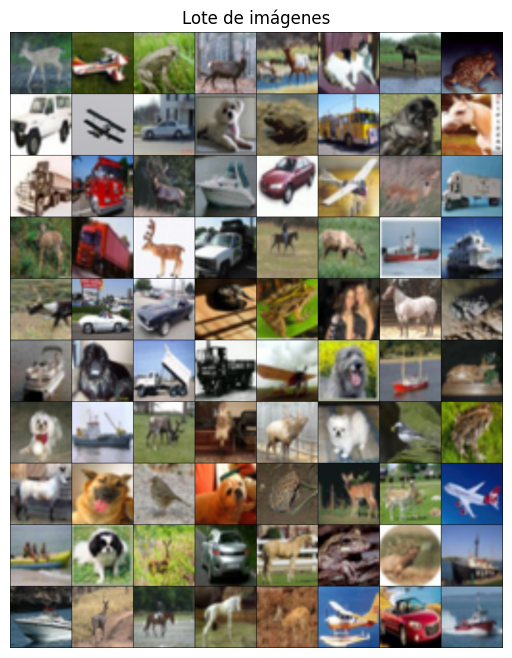

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),  # Convertir las imágenes a tensores

])

# Cargar el dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False, num_workers=2)


data_lote,labels_lote=next(iter(train_loader))

grid = make_grid(data_lote, nrow=8, padding=2)

# Convertir la cuadrícula a formato visualizable
grid_np = grid.permute(1, 2, 0).numpy()

# Mostrar la cuadrícula
plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Lote de imágenes')
plt.show()

In [11]:
torch.cuda.empty_cache()
del VGGNet

In [8]:
# Inicializar modelo, pérdida y optimizador
import torch.optim as optim
import torch

arch=[(2,64),(2,128),(3,256),(3,512),(3,512)] #arquitectura para vgg16

vgg16=VGGNet(arch=arch).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
epochs=15

modelo_entrenado,optimisador_entrenado=trainModel(vgg16,epochs,train_loader,test_loader,optimizer,criterion)

Épocas:   0%|          | 0/15 [00:00<?, ?it/s]

Epoca 1 - Dataloader:   0%|          | 0/625 [00:00<?, ?batches/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.14 GiB. GPU 0 has a total capacity of 14.75 GiB of which 97.06 MiB is free. Process 4832 has 14.65 GiB memory in use. Of the allocated memory 12.64 GiB is allocated by PyTorch, and 1.88 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Predicción: automobile
Probabilidad: 1.0000


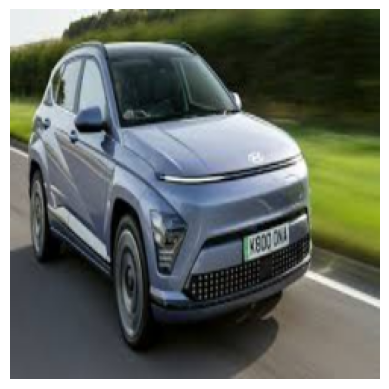

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

# Ruta de la imagen
file_path = "/content/images (4).jpg"  # @param {type:"string"}

# Cargar la imagen
img = Image.open(file_path)

# Transformaciones para la imagen: igual que durante el entrenamiento
transform = transforms.Compose([

    transforms.Resize((244, 244)),  # Redimensionar a 32x32
    transforms.ToTensor(),  # Convertir la imagen a tensor
])

# Aplicar las transformaciones

tensor_img= transform(img).unsqueeze(0)
tensor_img=tensor_img.to(device)
# Asegurarse de que el modelo esté en modo de evaluación
modelo_entrenado.eval()



# Hacer la predicción
with torch.no_grad():
    output = modelo_entrenado(tensor_img)

# Calcular las probabilidades con softmax
probabilities = F.softmax(output, dim=1)

# Obtener el índice de la clase con la mayor probabilidad
max_value, max_index = torch.max(probabilities, dim=1)

# Definir las clases (dígitos de 0 a 9)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Imprimir la predicción y la probabilidad
print(f'Predicción: {classes[max_index.item()]}')
print(f'Probabilidad: {max_value.item():.4f}')

tensor_img = tensor_img.squeeze(0)  # Eliminar la dimensión de batch, si es necesario

# Deshacer la normalización (si fue realizada previamente)



# Convertir de tensor a imagen PIL
to_pil = transforms.ToPILImage()
image = to_pil(tensor_img)
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para solo mostrar la imagen
plt.show()


In [ ]:
#Guardar modelo y optimzador:

torch.save({
    'model_state_dict': modelo_entrenado.state_dict(),  # Guardar solo los pesos del modelo
    'optimizer_state_dict': optimisador_entrenado.state_dict()  # Guardar el estado del optimizador
}, 'AlexNet_checkpoint.pth')





In [ ]:
#Cargar Modelo Entrenado

modelo = Alexnet(input_channel=3).to(device)  # Asegúrate de definir la clase antes
optimizer = optim.SGD(modelo.parameters())  # Define el optimizador

# Cargar el checkpoint
checkpoint = torch.load('AlexNet_checkpoint.pth')

# Restaurar el estado del modelo y el optimizador
modelo.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for param_group in optimizer.param_groups: #cambimos hiperparamtros de nuestro optimzador
    param_group['lr'] = 0.0001

epochs=10
modelo_entrenado,optimisador_entrenado=trainModel(modelo,epochs,train_loader,test_loader,optimizer,criterion)



<ipython-input-35-4a9f013dafa7>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('AlexNet_checkpoint.pth')


Épocas:   0%|          | 0/10 [00:00<?, ?it/s]

Epoca 1 - Dataloader:   0%|          | 0/313 [00:00<?, ?batches/s]

Época 1, Pérdida: 0.0341, Precisión: 0.8229


Epoca 2 - Dataloader:   0%|          | 0/313 [00:00<?, ?batches/s]

Época 2, Pérdida: 0.0346, Precisión: 0.8228


Epoca 3 - Dataloader:   0%|          | 0/313 [00:00<?, ?batches/s]